# TP1 : Linear regression

The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the prediction of the level of prostate specific antigen, denoted by `lpsa` below, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from numpy import linalg as la
from pylab import *
from sklearn.metrics import mean_squared_error

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 0 for the test set.

In [2]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [3]:
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

<AxesSubplot:>

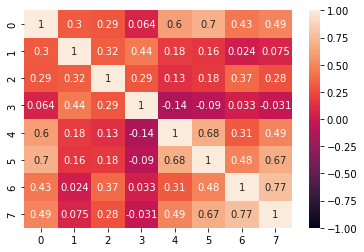

In [4]:
# Preliminary questions

#Autocovariance matrix
autocov_train = np.cov(M_train.T)
sns.heatmap(autocov_train, vmin=-1, vmax=1, annot=True)

OBSERVATIONS ET COMMENTAIRES : 

On peut voir qu'il existe des corrélations plus ou moins fortes entre les variables. Par exemple, entre les colonnes "gleason" et "pgg45" qui sont bien plus corrélées que les colonnes "pgg45" et "lweight".

De ce fait, on peut obtenir corrélations entre les différentes colonnes du dataset. Ainsi en prennant des données avec une corrélation forte (>0.7 en absolu) on peut presque avoir des regressions linéaires exploitables. Sauf que notre cas est de dimension supérieure, il nous faut donc des modèles plus puissants pour effectuer des régressions linéaires.

<AxesSubplot:>

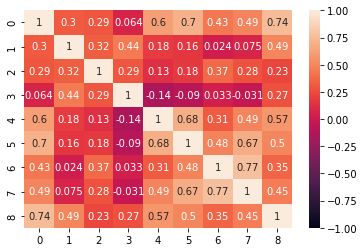

In [5]:
# We add the target column in this case
normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_trainb = np.array( [ normalize(vec) for vec in data_train[:,0:9].T ] ).T  # iterate on vec direct / ARRAY not LIST
autocov_train_with_target = np.cov((M_trainb).T)
sns.heatmap(autocov_train_with_target, vmin=-1, vmax=1, annot=True)

Ainsi, on peut voir qu'aucun feature n'a d'autocovariance très forte avec la target (duquel elle serait donc fortement dépendante). Donc la regression linéaire sur l'ensemble du dataset (et donc des features) est pertinente.

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [6]:
# Exercise 1

# Matrix of features
X_train = np.concatenate((np.ones((M_train.shape[0],1)),M_train),axis=1)

# Target matrix 
t_train = data_train[:,8]

# Estimation of the regression vector - method inv
beta_hat = np.dot(la.inv((X_train.T).dot(X_train)).dot(X_train.T),t_train)

# beta_hat[0]
print("beta_hat[0]: ", beta_hat[0])

beta_hat[0]:  2.4523450850746262


On obtient bien la moyenne des t_train, vu que la première colonne est uniquement composée de 1.

In [7]:
# Quadratic error from the test set
X_test = np.concatenate((np.ones((M_test.shape[0],1)),M_test),axis=1)
t_pred = np.dot(X_test, beta_hat) # Estimated targets
t_test = data_test[:,-2] # Real targets
quadratic_error = np.sqrt(mean_squared_error(t_test,t_pred)) # RMSE
print("Quadratic error: ", quadratic_error)

Quadratic error:  0.7219930785731955


L'erreur quadratique est donc plutôt faible, ce qui nous indique que notre estimateur est convenable.

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [8]:
# Exercise 2

# Computing the sigma hat
t_pred = np.dot(X_train, beta_hat)
residus = t_pred - t_train
sigma_hat = np.sqrt(np.sum(residus ** 2) / (M_train.shape[0] - M_train.shape[1] - 1))

# Computing the diagonal elements
diag_elements = np.diag(la.inv(X_train.T.dot(X_train)))

# Computing the Z-Scores
Z_scores = beta_hat / (sigma_hat * np.sqrt(diag_elements))

# Selecting the most significant entries
for i in range(len(Z_scores)):
    if np.abs(Z_scores[i]) < 2 :
        beta_hat[i] = 0

# New prediction error
X_test = np.concatenate((np.ones((M_test.shape[0],1)),M_test),axis=1)
t_pred_new = np.dot(X_test, beta_hat) # Estimated targets
t_test = data_test[:,-2] # Real targets
quadratic_error_z_scores = np.sqrt(mean_squared_error(t_test,t_pred_new)) # RMSE
print("Quadratic error - Z_scores: ", quadratic_error_z_scores)

Quadratic error - Z_scores:  0.6724779669796698


On a donc réussi à réduire l'erreur quadratique avec une méthode plus optimale.

In [9]:
# New regression vector when taking into account only the most significant entries
columns_to_keep = []
for i in range(len(Z_scores)):
    if np.abs(Z_scores[i]) >= 2 : # condition of significancy
        columns_to_keep.append(i)

X_train_most_significant = X_train[:, columns_to_keep]
t_train = data_train[:,8]
beta_hat = np.dot(la.inv((X_train_most_significant.T).dot(X_train_most_significant)).dot(X_train_most_significant.T),t_train)
print("beta_hat (with significant entries only): ", beta_hat)

beta_hat (with significant entries only):  [2.45234509 0.62345    0.25488273 0.20339287 0.2800554 ]


On peut donc bien voir que la dimensionnalité du problème a été réduite aux features considérées comme les plus importantes.

In [10]:
X_test = X_test[:, columns_to_keep]
t_pred_new = np.dot(X_test, beta_hat) # Estimated targets
t_test = data_test[:,-2] # Real targets
quadratic_error_z_scores = np.sqrt(mean_squared_error(t_test,t_pred_new)) # RMSE
print("Quadratic error - Z_scores (with significant entries only): ", quadratic_error_z_scores)

Quadratic error - Z_scores (with significant entries only):  0.675523591031551


On vient donc d'améliorer encore une fois l'erreur quadratique.

# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

In [11]:
# Exercise 3

# Ridge Regression
t = data_train[:,8]   # column of targets
t0 = np.mean(t)
tc = t - t0

# Penalty to apply
lambda_penalty = 25

# New regression vector
Xc = np.concatenate((np.ones((M_train.shape[0],1)),M_train),axis=1)
Ip = np.identity(Xc.shape[1])
beta_hat_reg = la.inv(lambda_penalty * Ip + (Xc.T) @ Xc) @ (Xc.T) @ tc
print("beta_hat_reg: ", beta_hat_reg)

# Predictions
X_test = np.concatenate((np.ones((M_test.shape[0],1)),M_test),axis=1)
t_pred_reg = np.dot(X_test, beta_hat_reg) + t0 # Estimated targets (non-centered)
t_test = data_test[:,-2] # Real targets
quadratic_error_reg = np.sqrt(mean_squared_error(t_test,t_pred_reg)) # RMSE
print("Quadratic error - Ridge Regression: ", quadratic_error_reg)

beta_hat_reg:  [-1.31838984e-16  4.22109201e-01  2.48791713e-01 -4.22649894e-02
  1.65753635e-01  2.30914852e-01  1.06632926e-02  4.30601734e-02
  1.31513164e-01]
Quadratic error - Ridge Regression:  0.7028101876836105


On a donc réussi à avoir des beta_hat_reg plus lissés et donc qui utilisent chacune des variables pour estimer la valeur à prédire (ce qui semble être optimal puisque l'ensemble des features en entrée avaient une covariance relativement élevée avec la sortie). Néanmoins, nous avons un peu augmenté l'erreur quadratique par rapport à la méthode des Z-scores, ce qui nous indique que le paramètre lambda n'est peut-être pas optimal dans ce cas.

In [12]:
# Compairing the results
beta_best = [2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0]
t_pred_best = np.dot(X_test, beta_best) + t0 # Estimated targets (non-centered)
quadratic_error_best = np.sqrt(mean_squared_error(t_test,t_pred_best)) # RMSE
print("\nQuadratic error - Best: ", quadratic_error_best)

# Old quadratic errors
print("Quadratic error - Z_scores: ", quadratic_error_z_scores)
print("Quadratic error - Ridge Regression: ", quadratic_error_reg)
print("Quadratic error: ", quadratic_error)


Quadratic error - Best:  2.567711974749767
Quadratic error - Z_scores:  0.675523591031551
Quadratic error - Ridge Regression:  0.7028101876836105
Quadratic error:  0.7219930785731955


On observe alors que l'erreur considérée comme "best" n'est pas la meilleure (donc celle qui minimiserait l'erreur quadratique) et que la méthode des Z_scores est pour l'instant la plus optimale. Il faudrait peut-être continuer à améliorer la valeur du paramètre lambda (comme suggéré juste avant) pour avoir une erreur quadratique plus faible dans le cas de la Ridge Regression.

# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [13]:
# Shuffling the dataset
ind_list = [i for i in range(data_train.shape[0])]
shuffle(ind_list)
data_train_shuffled  = data_train[ind_list, :]

In [14]:
# Exercise 4 

def cross_validation(data, lambda_max, N_crossval):
    # Defining variables and the error matrix
    lambda_pos = arange(0,lambda_max+1) 
    N_lines_in_dataset = int(data.shape[0] / N_crossval)
    error_matrix = np.zeros((N_crossval, lambda_max+1))

    for n in range(N_crossval):

        if n!= (N_crossval-1) :
            # Extraction of testset and trainset
            testset  = data[arange(n*N_lines_in_dataset,(n+1)*N_lines_in_dataset),0:9]
            trainset = data[hstack((arange(n*N_lines_in_dataset),arange((n+1)*N_lines_in_dataset,data_train.shape[0]))),0:9] 
            
        else :
            # In the case where N_lines_in_dataset isn't perfectly an integer, we select datasets until the last line available
            testset  = data[n*N_lines_in_dataset:,0:9] 
            trainset = data[hstack(arange(n*N_lines_in_dataset)),0:9]

        # Normalization of entries
        normalize = lambda vec: (vec-np.mean(vec))/np.std(vec) if np.std(vec)!=0 else vec    # inline function 
        testset_normalized = np.array( [ normalize(vec) for vec in testset[:,0:8].T ] ).T 
        trainset_normalized = np.array( [ normalize(vec) for vec in trainset[:,0:8].T ] ).T 

        # Normalization of targets
        testset_targets_normalized = testset[:,8] - np.mean(testset[:,8])
        trainset_targets_normalized = trainset[:,8] - np.mean(trainset[:,8])

        for l in lambda_pos:
            # Computation of the coefficients
            Xc = trainset_normalized.copy()
            Ip = np.identity(Xc.shape[1])
            beta_hat_reg = la.inv(l * Ip + (Xc.T) @ Xc) @ (Xc.T) @ trainset_targets_normalized # Calculation of beta hat
            t_pred_reg = np.dot(testset_normalized, beta_hat_reg) # Estimated targets
            quadratic_error_reg = np.sqrt(mean_squared_error(testset_targets_normalized,t_pred_reg)) # RMSE
            error_matrix[n,l] = quadratic_error_reg # Adding to the error matrix

    # Computing the mean error for each lambda of the matrix
    mean_error_per_lambda = np.mean(error_matrix, axis=0)
    
    return lambda_pos, mean_error_per_lambda

lambda_list, mean_error_per_lambda_list = cross_validation(data_train_shuffled, 40, 6)

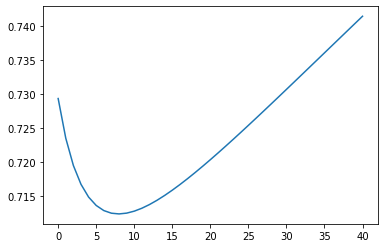

In [15]:
# Creating a graph to plot the RMSE for each lambda
plt.plot(lambda_list, mean_error_per_lambda_list)
plt.show()

On peut donc voir qu'on atteint un unique minimum qui correspondra à notre lambda à choisir, notre lambda optimal.

In [16]:
# Selecting the lambda that optimizes the error
optimal_lambda = lambda_list[np.argmin(mean_error_per_lambda_list)]
print("Le lambda à choisir est : ", optimal_lambda)
print("Son erreur quadratique moyenne (au sens du RMSE) est : ", mean_error_per_lambda_list[optimal_lambda])

Le lambda à choisir est :  8
Son erreur quadratique moyenne (au sens du RMSE) est :  0.7123095097283403


L'erreur quadratique a été augmentée, ce qui n'est pas ce que nous souhaitions. Il est peut-être alors nécessaire de modifier la valeur de N_crossval pour améliorer le score, étant le dernier paramètre sur lequel on peut agir.

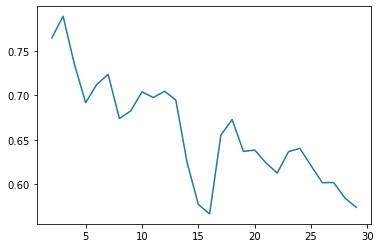

In [17]:
# Test for different values of N_crossval
optimal_lambda_list = []
mean_error_list = []
N_crossval_list = arange(2,30,1) # we choose 30 not to exceed half of the shape of the dataset

for i in N_crossval_list:
    lambda_list, mean_error_per_lambda_list = cross_validation(data_train_shuffled, 40, i)
    optimal_lambda = lambda_list[np.argmin(mean_error_per_lambda_list)]
    optimal_lambda_list.append(optimal_lambda)
    mean_error_list.append(mean_error_per_lambda_list[optimal_lambda])

# Plot to see the optimal value of N_crossval
plt.plot(N_crossval_list, mean_error_list)
plt.show()

On voit donc que l'on peut optimiser les deux paramètres à la fois afin d'obtenir un couple (lambda, N_crossval) qui nous donne une erreur quadratique la plus faible possible (voire plus faible que celle des Z-scores) et donc un estimateur le plus efficace possible.
Evidemment, ici, le mélange du dataset de départ va donner des résultats différents à chaque exécution, mais la tendance globale montre que l'on peut trouver un couple unique qui minimise cette erreur comme nous le souhaitons. 
Cette méthode est donc à privilégier afin d'obtenir une faible erreur, mais reste exigente en termes de coût d'exécution, au contraire de la méthode des Z-scores qui est moins coûteuse et qui parvient à des résultats similaires mais qui réduit la dimensionnalité du problème.